# SCI6485 Introduction to Generative Artificial Intelligence

##  StyleGAN + GANalyze + CLIP


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**  Sabrina Osmany<br/>
**TA:**  Jiabin Wei<br/>

**DISCLAIMER**: No public reproduction of this code is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---

# Manipulating StyleGAN Outputs with GANalyze Steering Mechanisms and CLIP Text Embeddings

This Jupyter notebook demonstrates how to manipulate the output of the StyleGAN2 model using steering mechanisms from GANalyze and CLIP text embeddings. In this notebook, we show how to use GANalyze steering mechanisms to manipulate the StyleGAN outputs in a controllable way based on semantic attributes. Specifically, we use CLIP text embeddings to guide the steering mechanism and produce desired images.

# Install dependencies and clone CLIP steering repository

In [ ]:
!python --version

Python 3.10.11


In [ ]:
!git clone https://github.com/fengqingthu/CLIP_Steering.git
!git clone https://github.com/openai/CLIP.git
# the line below is commented out because instead of the pre-trained StyleHuman which we saw in class, we will be replacing it with a different GAN that we train ourselves
# !git clone https://github.com/stylegan-human/StyleGAN-Human.git
#

Cloning into 'CLIP_Steering'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 25 (delta 8), reused 20 (delta 3), pack-reused 0
Receiving objects: 100% (25/25), 208.04 KiB | 18.91 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 1 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
!pip install \
  lpips \
  ftfy \
  regex \
  tqdm \
  git+https://github.com/openai/CLIP.git \
  click \
  requests \
  tqdm \
  pyspng \
  ninja \
  imageio-ffmpeg==0.4.3 \
  scipy

!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-r_gdvvaw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-r_gdvvaw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=93550958486eb9adb229a4ced7718caf79fa2c2a9a8be4a13f7b0deff7f792c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-m787telf/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
/bin/bash: line 1: conda: command not found


In [ ]:
# mount files from google drive
# and follow the steps here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# (skip) Get the StyleGan - human model

## Download pretrained models

In [ ]:
import os

repo_name = "StyleGAN-Human"

def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), f'{repo_name}',"pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [ ]:
MODEL_PATHS = {
    "stylegan1_1024": {"id": "1h-R-IV-INGdPEzj4P9ml6JTEvihuNgLX", "name": "stylegan1_1024.pkl"},
    "stylegan2_1024": {"id": "1FlAb1rYa0r_--Zj_ML8e6shmaF28hQb5", "name": "stylegan2_1024.pkl"},
    "stylegan2_512": {"id": "1dlFEHbu-WzQWJl7nBBZYcTyo000H9hVm", "name": "stylegan2_512.pkl"},
    "stylegan3_512": {"id": "1_274jk_N6WSCkKWeu7hjHycqGvbuOFf5", "name": "stylegan3_512.pkl"},
    # "stylegan3_1024": {"id": None, "name": "stylegan3_1024.pkl"},
    # "stylegan1_512": {"id": None, "name": "stylegan1_512.pkl"},
}

In [ ]:
#@title Select which experiment you wish to perform inference on: { run: "auto" }
experiment_type = 'stylegan2_1024' #@param ['stylegan1_1024', 'stylegan2_1024', 'stylegan1_512', 'stylegan2_512', 'stylegan3_512']

In [ ]:
path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])
!{download_command}

--2023-05-07 07:05:22--  https://docs.google.com/uc?export=download&confirm=t&id=1FlAb1rYa0r_--Zj_ML8e6shmaF28hQb5
Resolving docs.google.com (docs.google.com)... 142.250.159.113, 142.250.159.139, 142.250.159.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.159.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8iqmg3djtshilr9lvda8ne6vv1tepdp8/1683443100000/01844016854614948534/*/1FlAb1rYa0r_--Zj_ML8e6shmaF28hQb5?e=download&uuid=ee2ab70e-2d87-42be-89f7-944f1950ee40 [following]
--2023-05-07 07:05:23--  https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8iqmg3djtshilr9lvda8ne6vv1tepdp8/1683443100000/01844016854614948534/*/1FlAb1rYa0r_--Zj_ML8e6shmaF28hQb5?e=download&uuid=ee2ab70e-2d87-42be-89f7-944f1950ee40
Resolving doc-10-10-docs.googleusercontent.com (doc-10-10-docs.googleusercontent.com)... 74.125.70.13

# Get a StyleGan model

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c2403b80-45d4-8c35-de3f-42a64b474136)


In [ ]:
import torch
import torchvision
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

Selected device: cuda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9


In [ ]:
# clone StyleGan repo from github
!git clone https://github.com/NVlabs/stylegan3

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 16.43 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
%cd stylegan3

import stylegan3
import dnnlib
import legacy

import os
import re
from typing import List, Optional, Tuple, Union

import click

import numpy as np
import PIL.Image
import torch

%cd /content

/content/stylegan3
/content


In [ ]:
def get_G(
    network_pkl: str,
    class_idx: Optional[int]
    ):

    print('Loading networks from "%s"...' % network_pkl)

    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

    if G.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')

    return G


def generate_stylegan_images(
    G,
    z,
    y,
    truncation_psi: float = 1,
    noise_mode: str = 'const',
):
    # Generate images.
    w = G.mapping(z, y, truncation_psi=truncation_psi)
    imgs = G.synthesis(w, noise_mode=noise_mode, force_fp32 = True)

    imgs = (
        (imgs.permute(0, 2, 3, 1) * 127.5 + 128)
        .clamp(0, 255)
        .to(torch.uint8)
        .cpu()
        .numpy()
    )
    return [PIL.Image.fromarray(img, 'RGB') for img in imgs]


# Import all dependencies

Make sure to add CLIP_steering into the path so that we can use the GANAlyze tools.

In [ ]:
import logging
import os
import pathlib
import sys

import clip
import IPython.display
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

#
# sys.path.insert(0, "./StyleGAN-Human")
sys.path.insert(0, "./StyleGAN")
sys.path.insert(0, "./CLIP_Steering")
try:
    import ganalyze_common_utils as common
    import ganalyze_transformations as transformations
except ImportError as ex:
    print("Could not import ganalyze_common_utils or ganalyze_transformations", ex)

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "MAX_SPLIT_SIZE_1=32MB"

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

# Declare helper functions

These functions are useful for showing and generating GAN images. We leverage a lot of the BigGAN functions like `one_hot_from_int` or `convert_to_images`.

In [ ]:
#@title (skip) StyleGAN-human Helper functions

# Copyright (c) SenseTime Research. All rights reserved.

# Copyright (c) 2019, NVIDIA Corporation. All rights reserved.
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://nvlabs.github.io/stylegan2/license.html


## this script is for generating images from pre-trained network based on StyleGAN1 (TensorFlow) and StyleGAN2-ada (PyTorch) ##
import dnnlib
import PIL.Image
import legacy
from typing import List, Optional
import torch

version = 2
network_pkl = f"/StyleGAN-Human/pretrained_models/{experiment_type}.pkl"

print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


def generate_stylegan_v2_images(
    G,
    z,
    y,
    truncation_psi: float = 1,
    noise_mode: str = 'const',
):
    # Generate images.
    w = G.mapping(z, y, truncation_psi=truncation_psi)
    imgs = G.synthesis(w, noise_mode=noise_mode, force_fp32 = True)

    imgs = (
        (imgs.permute(0, 2, 3, 1) * 127.5 + 128)
        .clamp(0, 255)
        .to(torch.uint8)
        .cpu()
        .numpy()
    )
    return [PIL.Image.fromarray(img, 'RGB') for img in imgs]



Loading networks from "/StyleGAN-Human/pretrained_models/stylegan2_1024.pkl"...


In [ ]:
#@title (skip) helper functions

from PIL import Image
from typing import Optional, Tuple

def show_images(
        images: list[Image.Image],
        resize: Optional[Tuple[int, int]] = None
    ):
    """Show a list of images in a row."""
    images = [np.array(img) for img in images]
    images = np.concatenate(images, axis=1)
    images = Image.fromarray(images)

    if resize:
        images.thumbnail(resize)

    IPython.display.display(images)


def show_and_save_images(
    images: list[Image.Image], batch: int, path: str, variant: str = "original"
):
    show_images(images)

    if not os.path.exists(path):
        os.makedirs(path)

    for i, img in enumerate(images):
        img.save(f"{path}/image_{batch}_{i}_{variant}.png")


def show_gan_results(gan_results: List[List[Tuple[Image.Image, np.ndarray]]]):
    for batch_results in gan_results:
        batch_size = len(batch_results[0][0])

        for i in range(batch_size):
            steering_images = [res[0][i] for res in batch_results]
            steering_scores = np.stack(
                [res[1][i].detach().cpu().numpy() for res in batch_results]
            ).tolist()
            print(steering_scores)
            show_images(steering_images, resize=(1024, 256))


def make_noise_and_class_vectors(num_samples: int, seed=None):
    noise_vector = torch.from_numpy(
        np.random.RandomState(seed).randn(num_samples, G.z_dim)
    ).to(device)
    class_vector = torch.zeros([num_samples, G.c_dim], device=device)

    return noise_vector, class_vector

def get_clip_probs(image_inputs, text_features, model, attribute_index=0):
    image_inputs = torch.stack([preprocess(img.resize((512, 512))) for img in image_inputs]).to(device)
    image_features = model.encode_image(image_inputs).float()

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    # cosine similarity as logits
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()

    clip_probs = logits_per_image.softmax(dim=-1)

    return clip_probs.narrow(dim=-1, start=attribute_index, length=1).squeeze(dim=-1)


def make_images_and_probs(
    model, z, y, truncation, clip_model, encoded_text, attribute_index=0
):
    gan_images = generate_stylegan_v2_images(model, z, y, truncation_psi=truncation)
    clip_probs = get_clip_probs(gan_images, encoded_text, clip_model, attribute_index)

    return gan_images, clip_probs

In [ ]:
#@title StyleGAN Helper functions
from PIL import Image
from typing import Optional, Tuple

def show_images(
        images: list[Image.Image],
        resize: Optional[Tuple[int, int]] = None
    ):
    """Show a list of images in a row."""
    images = [np.array(img) for img in images]
    images = np.concatenate(images, axis=1)
    images = Image.fromarray(images)

    if resize:
        images.thumbnail(resize)

    IPython.display.display(images)


def show_and_save_images(
    images: list[Image.Image], batch: int, path: str, variant: str = "original"
):
    show_images(images)

    if not os.path.exists(path):
        os.makedirs(path)

    for i, img in enumerate(images):
        img.save(f"{path}/image_{batch}_{i}_{variant}.png")


def show_gan_results(gan_results: List[List[Tuple[Image.Image, np.ndarray]]]):
    for batch_results in gan_results:
        batch_size = len(batch_results[0][0])

        for i in range(batch_size):
            steering_images = [res[0][i] for res in batch_results]
            steering_scores = np.stack(
                [res[1][i].detach().cpu().numpy() for res in batch_results]
            ).tolist()
            print(steering_scores)
            show_images(steering_images, resize=(1024, 256))


def make_noise_and_class_vectors(num_samples: int, seed=None):
    noise_vector = torch.from_numpy(
        np.random.RandomState(seed).randn(num_samples, G.z_dim)
    ).to(device)
    class_vector = torch.zeros([num_samples, G.c_dim], device=device)

    return noise_vector, class_vector

def get_clip_probs(image_inputs, text_features, model, attribute_index=0):
    image_inputs = torch.stack([preprocess(img.resize((512, 512))) for img in image_inputs]).to(device)
    image_features = model.encode_image(image_inputs).float()

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    # cosine similarity as logits
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()

    clip_probs = logits_per_image.softmax(dim=-1)

    return clip_probs.narrow(dim=-1, start=attribute_index, length=1).squeeze(dim=-1)


def make_images_and_probs(
    model, z, y, truncation, clip_model, encoded_text, attribute_index=0
):
    gan_images = generate_stylegan_images(model, z, y, truncation_psi=truncation)
    clip_probs = get_clip_probs(gan_images, encoded_text, clip_model, attribute_index)

    return gan_images, clip_probs


# (skip) Test StyleGAN-human

Check that StyleGAN works fine.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

truncation = 1.0
noise_vector, class_vector = make_noise_and_class_vectors(
    num_samples=4
)

# Generate an image
output_images = generate_stylegan_v2_images(
    G, noise_vector, class_vector, truncation_psi=truncation
)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


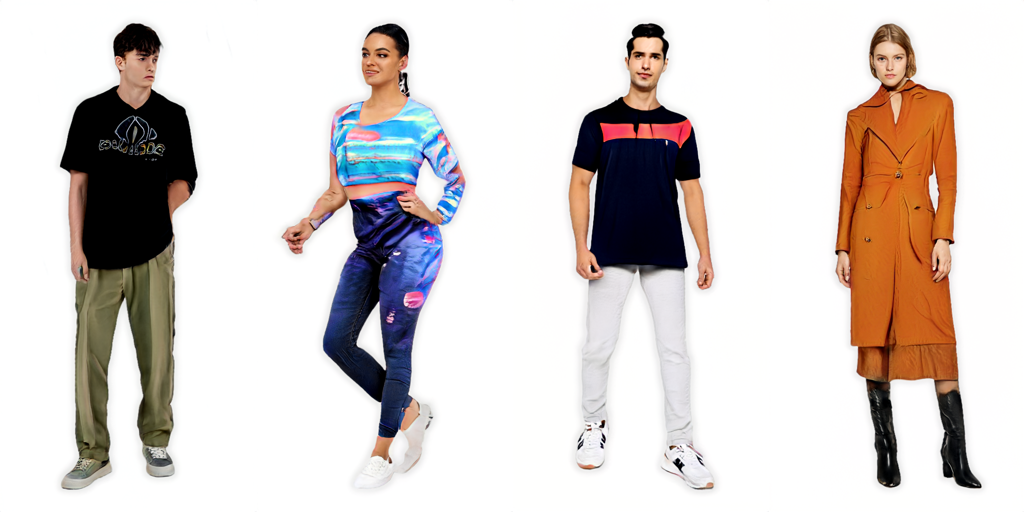

In [ ]:
show_images(output_images, resize=(1024, 1024))

# Test StyleGan

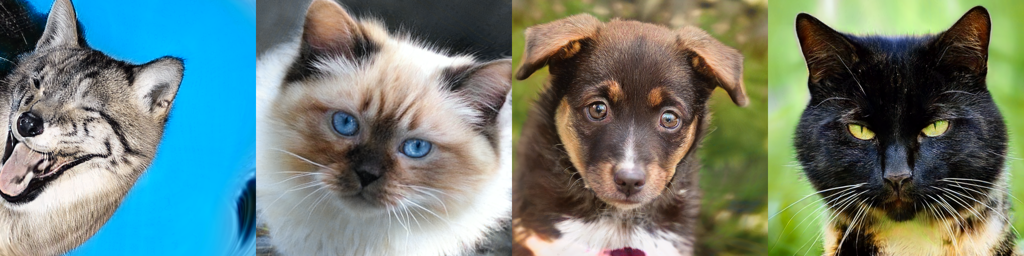

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = get_G('https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl', class_idx=None)

truncation = 1.0

make_noise_and_class_vectors
noise_vector, class_vector = make_noise_and_class_vectors(
    num_samples=4
)

# Generate 4 images
output_images = generate_stylegan_images(
    G, noise_vector, class_vector, truncation_psi=truncation
)
show_images(output_images, resize=(1024, 1024))

# Import and test CLIP model

Check that the CLIP model works fine. We import CLIP by installing it through PIP. We cloned CLIP's repo to get the CLIP/CLIP.png test image.

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
clip_model.to(device)

image = preprocess(Image.open("CLIP/CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)

    logits_per_image, logits_per_text = clip_model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()


print(image.shape, image_features.shape, text_features.shape)
print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

torch.Size([1, 3, 224, 224]) torch.Size([1, 512]) torch.Size([3, 512])
Label probs: [[0.9927   0.004253 0.003016]]


In [ ]:
torch.cuda.empty_cache()
latent_space_dim = (
    G.z_dim
)  # I added this manually from info at: https://github.com/huggingface/pytorch-pretrained-BigGAN/blob/master/README.md
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}",
)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Latent space dimension:", latent_space_dim)

Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Latent space dimension: 512


## Use CLIP to extract target text attributes

Use the CLIP model to extract target text attributes for steering the output of a GAN. We use the CLIP tokenizer and encoder to extract text features and normalize them.

The resulting text features are used later to steer the GAN output towards the desired attribute.

In [ ]:
# Extract text features for clip

# Here is how we specify the desired attributes
attributes = ["a cat with a black face and blue eyes", "a person"]
attribute_index = 0  # which attribute do we want to maximize
text_descriptions = [f"{label}" for label in attributes]


with torch.no_grad():
    text_tokens = clip.tokenize(text_descriptions).to(device)
    text_features = clip_model.encode_text(text_tokens).float()
    # text_features = F.normalize(text_features, p=2, dim=-1)

text_features.shape

torch.Size([2, 512])

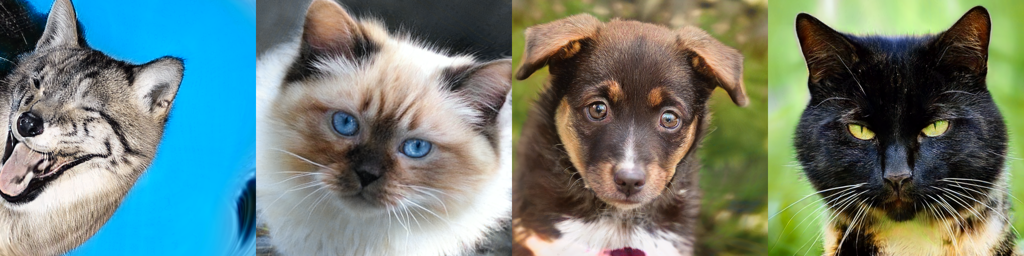

In [ ]:
show_images(output_images, resize=(1024, 1024))

In [ ]:
get_clip_probs(output_images, text_features, clip_model, 0)

tensor([0.9955, 1.0000, 0.2338, 0.9986], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

# Declare the GAN streering model

This is the model in charge of changing the vectors `z` so that it aligns with the objective declared in `text_features`.

In [ ]:
transformation = transformations.OneDirection(latent_space_dim, vocab_size)
transformation = transformation.to(device)

checkpoint_dir = "checkpoints/results_maximize_clip_probability"
checkpoint_name = "pytorch_model_stylegan2_luxurious.pth"


approach:  one_direction



# Traning steps

Now we're ready to train the GAN steering model called `transformation`. The overall algorithm looks like this:

1. Generate the noise and class vectors for a given number of training samples.
2. For each batch, generate the GAN images and calculate the CLIP scores comparing the images features correlation with the target text features.
3. Use the `transformation` model to adjust the original noise. Repeat step 2 for the transformed noise `z_transformed`.
4. Compare the scoring output, and make the model optimize to minimize the difference between the target scores and the resulting one after transforming the original noise.



In [ ]:
# clear GPU memory
import gc
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

In [ ]:
from tqdm.notebook import tqdm

optimizer = torch.optim.Adam(
    transformation.parameters(), lr=0.0002
)  # as specified in GANalyze
losses = common.AverageMeter(name="Loss")

#  training settings
optim_iter = 0
batch_size = 18  # Do not change
train_alpha_a = -0.5  # Lower limit for step sizes
train_alpha_b = 0.5  # Upper limit for step sizes
#
# Number of samples to train for # Ganalyze uses 400,000 samples.
# Use smaller number for testing.
#
num_samples = 6000

# Specify the parameters to create the noise and vector classes
truncation = 1.0

# CHANGE. How to initialize noise and class vectors
noise_vector, class_vector = make_noise_and_class_vectors(
    num_samples
)

attribute_index = 0
pathlib.Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

progress = tqdm("Training", total=len(range(0, num_samples, batch_size)))

# loop over data batches
for batch_start in range(0, num_samples, batch_size):
    #
    # Setup the batch z and y vectors. Also sample step sizes.
    #
    s = slice(batch_start, min(num_samples, batch_start + batch_size))

    z = noise_vector[s]
    y = class_vector[s]

    step_sizes = (train_alpha_b - train_alpha_a) * np.random.random(
        size=(batch_size)
    ) + train_alpha_a  # sample step_sizes

    step_sizes_broadcast = np.repeat(step_sizes, latent_space_dim).reshape(
        [batch_size, latent_space_dim]
    )
    step_sizes_broadcast = (
        torch.from_numpy(step_sizes_broadcast).type(torch.FloatTensor).to(device)
    )

    #
    # Generate the original images and get their clip scores
    #
    gan_images, out_scores = make_images_and_probs(
        model=G.to(device),
        z=z,
        y=y,
        truncation=truncation,
        clip_model=clip_model.to(device),
        encoded_text=text_features,
        attribute_index=attribute_index,
    )

    # TODO: ignore z vectors with less confident clip scores
    target_scores = torch.clip(
        out_scores + torch.from_numpy(step_sizes).to(device).float(),
        0.0,
        1.0
    )

    #
    # Transform the z vector and get the clip scores for the transformed images
    #
    z_transformed = transformation.transform(z, y, step_sizes_broadcast)
    gan_images_transformed, out_scores_transformed = make_images_and_probs(
        model=G,
        z=z_transformed,
        y=y,
        truncation=truncation,
        clip_model=clip_model,
        encoded_text=text_features,
        attribute_index=attribute_index,
    )

    #
    # Compute loss and backpropagate
    #
    loss = transformation.criterion(out_scores_transformed, target_scores)

    loss.backward()
    optimizer.step()

    #
    # Print and save intermediate results
    #
    losses.update(loss.item(), batch_size)
    if optim_iter % 50 == 0:
        print(
            f"[Maximizing score for CLIP] "
            f"Progress: [{batch_start}/{num_samples}] {losses}"
        )

        print(
            f"[Scores] "
            f"Target: {target_scores} Out: {out_scores_transformed}"
        )

    if optim_iter % 200 == 0:
        batch_checkpoint_name = f"pytorch_model_stylegan2_human_{batch_start}.pth"
        torch.save(
            transformation.state_dict(),
            os.path.join(checkpoint_dir, batch_checkpoint_name)
        )

        # plot and save sample images
        # show_and_save_images(gan_images, batch_start, checkpoint_dir)
        # show_and_save_images(
        #     gan_images_transformed, batch_start, checkpoint_dir, "transformed"
        # )

    optim_iter = optim_iter + 1
    progress.update(1)

  0%|          | 0/334 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
torch.save(
    transformation.state_dict(),
    checkpoint_path
)

print (checkpoint_path)

checkpoints/results_maximize_clip_probability/pytorch_model_stylegan2_luxurious.pth


In [ ]:
save_path = '/content/drive/MyDrive/StyleHuman/'

In [ ]:
torch.save(
    transformation.state_dict(),
    save_path + checkpoint_name
)

print (checkpoint_name)

pytorch_model_stylegan2_luxurious.pth


## (skip)

In [ ]:
!rm -rf Weights
!mkdir -p Weights
!cp $checkpoint_path "/content/gdrive/MyDrive/Colab Notebooks/Sabrina <> Leo/Weights"
!cp $checkpoint_path "Weights/"

cp: cannot create regular file '/content/gdrive/MyDrive/Colab Notebooks/Sabrina <> Leo/Weights': No such file or directory


In [ ]:
!rm -rf Weights
!mkdir -p Weights
!cp $checkpoint_path "/content/drive/MyDrive/StyleHuman"
!cp $checkpoint_path "Weights/"

# Testing steps

Now that the model is trained, we can test it and see how the output changes when incrementing and decrementing the step_sizes on our `z` vectors.

We take the latest saved checkpoint located at `{checkpoint_dir}/pytorch_model_final.pth`.

Clone the CLIP repo and test that it works

In [ ]:
#
# Now that the model is trained, we can test it.
#
# Testing the model involves using the transformation model to transform a z vector and then
# using the GAN model to generate an image from the transformed z vector.
# We will change the step size and see how the image changes.
#
batch_size = 6  # Do not change
alpha = 0.2
num_samples = 6

truncation = 1.0
noise_vector, class_vector = make_noise_and_class_vectors(
    num_samples
)

iters = 6

transformation = transformations.OneDirection(latent_space_dim)
transformation.load_state_dict(
    torch.load(
        os.path.join(save_path, checkpoint_name),
    ),
    strict=True,
)
transformation.to(device)
transformation.eval()

gan_results = []

with torch.no_grad():
    for batch_start in range(0, num_samples, batch_size):
        #
        # Setup the batch z and y vectors. Also sample step sizes.
        #
        s = slice(batch_start, min(num_samples, batch_start + batch_size))

        z = noise_vector[s]
        y = class_vector[s]

        step_sizes = (
            (torch.ones((batch_size, latent_space_dim)) * alpha).float().to(device)
        )

        gan_images, out_scores = make_images_and_probs(
            model=G,
            z=z,
            y=y,
            truncation=truncation,
            clip_model=clip_model,
            encoded_text=text_features,
            attribute_index=attribute_index,
        )

        batch_results = [(gan_images, out_scores)]

        # Generate images by transforming the z vector in the negative direction
        z_negative = z.clone()

        for iter in range(iters):
            z_negative = transformation.transform(z_negative, y, -step_sizes)
            batch_results.insert(
                0,
                make_images_and_probs(
                    model=G,
                    z=z_negative,
                    y=y,
                    truncation=truncation,
                    clip_model=clip_model,
                    encoded_text=text_features,
                    attribute_index=attribute_index,
                )
            )

        # Generate images by transforming the z vector in the positive direction
        z_positive = z.clone()

        for iter in range(iters):
            z_positive = transformation.transform(z_positive, y, step_sizes)
            batch_results.append(
                make_images_and_probs(
                    model=G,
                    z=z_positive,
                    y=y,
                    truncation=truncation,
                    clip_model=clip_model,
                    encoded_text=text_features,
                    attribute_index=attribute_index,
                )
            )

        gan_results.append(batch_results)


approach:  one_direction



NotADirectoryError: ignored

[0.06053589656949043, 0.05821017548441887, 0.06484614312648773, 0.09480136632919312, 0.09230952709913254, 0.3280344009399414, 0.40524643659591675, 0.5066286325454712, 0.6411138772964478, 0.5419756174087524, 0.4915831983089447, 0.5227689743041992, 0.6865568161010742]


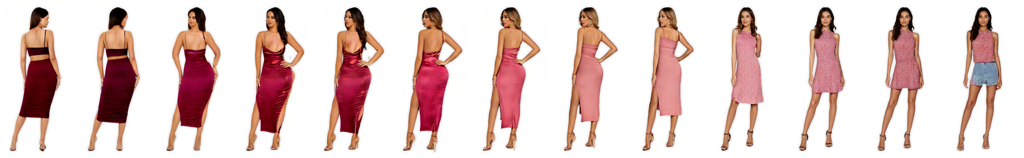

[0.3158414661884308, 0.3407687544822693, 0.3692431151866913, 0.7109473943710327, 0.6249536275863647, 0.5481089949607849, 0.4476073980331421, 0.4865526258945465, 0.2274395227432251, 0.1375284045934677, 0.18722786009311676, 0.24883460998535156, 0.4035209119319916]


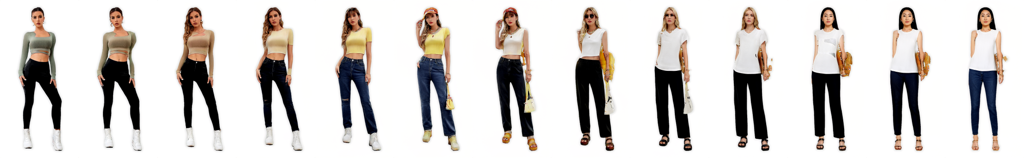

[0.09358250349760056, 0.13731947541236877, 0.1877889782190323, 0.12209752202033997, 0.16200707852840424, 0.40603554248809814, 0.261311411857605, 0.3094083070755005, 0.3443422317504883, 0.40209585428237915, 0.3000192642211914, 0.39278075098991394, 0.4011007249355316]


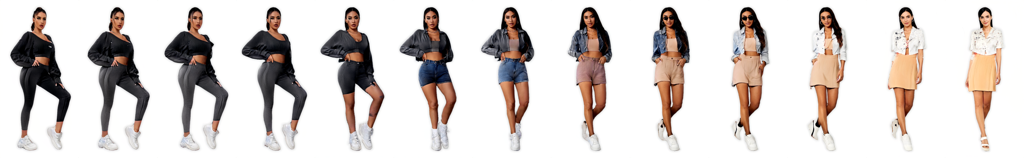

[0.332268089056015, 0.5205615162849426, 0.5716185569763184, 0.5208157300949097, 0.6266129612922668, 0.7207784056663513, 0.6767300963401794, 0.5304763913154602, 0.6991373300552368, 0.4415384829044342, 0.3626424968242645, 0.24692964553833008, 0.2223585993051529]


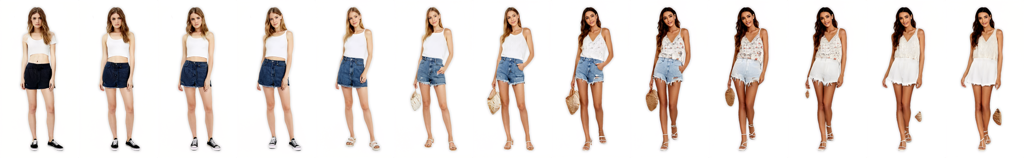

[0.2161272019147873, 0.13131871819496155, 0.12413106113672256, 0.24310295283794403, 0.0945277288556099, 0.15569551289081573, 0.26492738723754883, 0.17983503639698029, 0.15451525151729584, 0.08847666531801224, 0.15729252994060516, 0.4437675476074219, 0.3821553885936737]


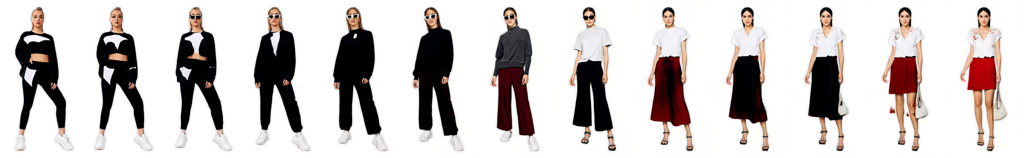

[0.07216683775186539, 0.04801002889871597, 0.10614248365163803, 0.6561855673789978, 0.6391375660896301, 0.7142638564109802, 0.8094893097877502, 0.7457782626152039, 0.7058277726173401, 0.5247001051902771, 0.5620905756950378, 0.5200849771499634, 0.6482036709785461]


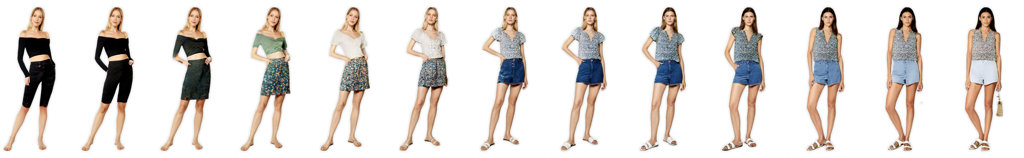

In [ ]:
show_gan_results(gan_results)